<a href="https://colab.research.google.com/github/valeriad0l/Voice-Based-Sentiment-Analysis/blob/main/hybrid_emotion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detection from Speech Using Deep Learning and Spectrogram Analysis

##*A CNN Approach Using YAMNet Embeddings and Mel-Spectrogram Features*

This notebook implements a hybrid model for **speech emotion recognition**.  
It uses **Mel spectrograms** and **YAMNet embeddings** as input features and classifies audio samples into three emotion categories: `happy`, `sad`, `angry`.

In [1]:
# ---📦 INSTALL DEPENDENCIES ---
!pip install librosa pydub matplotlib seaborn scikit-learn tensorflow_hub --quiet

In [2]:
# ---📚 IMPORTS ---
import os
import random
import zipfile
import pickle
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, concatenate, Attention, Reshape, GlobalAveragePooling1D, Concatenate, GlobalAveragePooling2D)

In [3]:
# ---🔊 LOAD YAMNET MODEL ---
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def extract_yamnet_embedding(file_path):
    """Extracts a YAMNet embedding from a given .wav audio file.

    Source
    ------
    Adapted from the official YAMNet TensorFlow Hub documentation:
    https://tfhub.dev/google/yamnet/1

    Original logic adapted and modified for averaging and padding consistency.

    Arguments
    ---------
    file_path : str
        Path to the input WAV audio file.

    Returns
    -------
    np.ndarray
        A 1024-dimensional average embedding vector.

    Example
    -------
    >>> embedding = extract_yamnet_embedding('audio.wav')
    """
    waveform, sr = librosa.load(file_path, sr=16000)
    waveform = waveform[:sr * 10]
    waveform = np.pad(waveform, (0, max(0, sr * 10 - len(waveform))), 'constant')

    scores, embeddings, spectrogram = yamnet_model(waveform)

    # embeddings might already be a NumPy array; ensure conversion just in case
    return np.mean(np.array(embeddings), axis=0)

In [4]:
# ---📁 UPLOAD KAGGLE API KEY & DOWNLOAD DATASETS ---
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/cremad

with zipfile.ZipFile("ravdess-emotional-speech-audio.zip", 'r') as zip_ref:
    zip_ref.extractall("ravdess_data")

with zipfile.ZipFile("toronto-emotional-speech-set-tess.zip", 'r') as zip_ref:
    zip_ref.extractall("tess_data")

with zipfile.ZipFile("cremad.zip", 'r') as zip_ref:
    zip_ref.extractall("crema_data")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)


In [5]:
# ---📍 PATHS ---
ravdess_path = "ravdess_data"
tess_path = "tess_data"
crema_path = "crema_data"

In [6]:
# ---🎼 MEL-SPECTROGRAM FUNCTION ---
def audio_to_mel_spectrogram(file_path, n_mels=128, max_len=128, augment=False):
    """Generates a Mel spectrogram from a given .wav file, with optional augmentation.

    Source
    ------

    Adapted from librosa documentation examples:
    https://librosa.org/doc/latest/feature.html

    Original logic adapted and modified for averaging and padding consistency.

    Arguments
    ---------
    file_path : str
        Path to the audio file.
    n_mels : int
        Number of Mel frequency bins.
    max_len : int
        Maximum number of time frames.
    augment : bool
        Whether to apply pitch/time/noise augmentation.

    Returns
    -------
    np.ndarray
        2D Mel spectrogram of shape (n_mels, max_len).

    Example
    -------
    >>> mel = audio_to_mel_spectrogram('audio.wav', augment=True)
    """
    y, sr = librosa.load(file_path, sr=None)
    if augment:
        if random.random() < 0.5:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.choice([-3, -2, -1, 1, 2, 3]))
        if random.random() < 0.5:
            y = librosa.effects.time_stretch(y, rate=random.uniform(0.8, 1.2))
        if random.random() < 0.3:
            y += 0.005 * np.random.uniform() * np.amax(y) * np.random.normal(size=y.shape)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return np.pad(mel_db, ((0, 0), (0, max(0, max_len - mel_db.shape[1]))), mode='constant')[:, :max_len]

In [7]:
# ---🧾 LOAD FILEPATHS & LABELS ---
def load_emotion_datasets(ravdess_path, tess_path, crema_path):
    """
    Loads and labels audio file paths from the RAVDESS, TESS, and CREMA-D datasets.

    Each dataset is parsed according to its specific directory structure and filename encoding,
    and only samples labeled as 'happy', 'sad', or 'angry' are retained. The final output includes
    a labeled DataFrame for each dataset.

    Parameters
    ----------
    ravdess_path : str
        Path to the root directory containing RAVDESS audio files.
    tess_path : str
        Path to the root directory containing TESS audio files.
    crema_path : str
        Path to the root directory containing CREMA-D audio files.

    Returns
    -------
    df_ravdess : pd.DataFrame
        DataFrame containing file paths and emotion labels for the RAVDESS dataset.
    df_tess : pd.DataFrame
        DataFrame containing file paths and emotion labels for the TESS dataset.
    df_crema : pd.DataFrame
        DataFrame containing file paths and emotion labels for the CREMA-D dataset.

    Example
    -------
    >>> df_ravdess, df_tess, df_crema = load_emotion_datasets("ravdess_data", "tess_data", "crema_data")
    """
    emotion_map_ravdess = {'03': 'happy', '04': 'sad', '05': 'angry'}
    ravdess_filepaths, ravdess_emotions = [], []
    for root, _, files in os.walk(ravdess_path):
        for file in files:
            if file.endswith(".wav"):
                code = file.split('-')[2]
                if code in emotion_map_ravdess:
                    ravdess_filepaths.append(os.path.join(root, file))
                    ravdess_emotions.append(emotion_map_ravdess[code])
    df_ravdess = pd.DataFrame({'file': ravdess_filepaths, 'label': ravdess_emotions})

    target_emotions = ['happy', 'sad', 'angry']
    tess_filepaths, tess_emotions = [], []
    for root, _, files in os.walk(tess_path):
        for file in files:
            if file.endswith(".wav"):
                for emotion in target_emotions:
                    if emotion in root.lower():
                        tess_filepaths.append(os.path.join(root, file))
                        tess_emotions.append(emotion)
                        break
    df_tess = pd.DataFrame({'file': tess_filepaths, 'label': tess_emotions})

    crema_filepaths, crema_emotions = [], []
    for root, _, files in os.walk(os.path.join(crema_path, "AudioWAV")):
        for file in files:
            if file.endswith(".wav"):
                parts = file.split('_')
                if len(parts) > 2:
                    label = {'HAP': 'happy', 'SAD': 'sad', 'ANG': 'angry'}.get(parts[2])
                    if label:
                        crema_filepaths.append(os.path.join(root, file))
                        crema_emotions.append(label)
    df_crema = pd.DataFrame({'file': crema_filepaths, 'label': crema_emotions})

    return df_ravdess, df_tess, df_crema

In [8]:
def combine_emotion_dataframes(df_ravdess, df_tess, df_crema):
    """
    Concatenates the labeled DataFrames from RAVDESS, TESS, and CREMA-D datasets
    into a single combined dataset and prints dataset statistics.

    Parameters
    ----------
    df_ravdess : pd.DataFrame
        DataFrame containing labeled file paths from the RAVDESS dataset.
    df_tess : pd.DataFrame
        DataFrame containing labeled file paths from the TESS dataset.
    df_crema : pd.DataFrame
        DataFrame containing labeled file paths from the CREMA-D dataset.

    Returns
    -------
    df_combined : pd.DataFrame
        Unified DataFrame containing all file paths and labels from the three datasets.

    Example
    -------
    >>> df_combined = combine_emotion_dataframes(df_ravdess, df_tess, df_crema)
    """
    df_combined = pd.concat([df_ravdess, df_tess, df_crema], ignore_index=True)
    print("Dataset size:", len(df_combined))
    print(df_combined['label'].value_counts())
    return df_combined

In [9]:
# ---👥 STRATIFIED SPEAKER SPLIT ---
def extract_speaker_id(file_path):
    """
    Extracts the speaker ID based on the dataset file path structure.

    Args:
        file_path (str): Full path to the audio file.

    Returns:
        str: Extracted speaker ID.

    Example:
        speaker_id = extract_speaker_id("crema_data/AudioWAV/1001_SAD_XXX.wav")
    """
    filename = os.path.basename(file_path)
    if 'ravdess' in file_path:
        return filename.split('-')[0]
    elif 'tess' in file_path:
        return file_path.split('/')[-2]
    elif 'crema' in file_path:
        return filename.split('_')[0]
    return "unknown"

# Load labeled datasets
df_ravdess, df_tess, df_crema = load_emotion_datasets(ravdess_path, tess_path, crema_path)

# Combine them into one dataframe
df_combined = combine_emotion_dataframes(df_ravdess, df_tess, df_crema)

# Extract speaker IDs
df_combined['speaker_id'] = df_combined['file'].apply(extract_speaker_id)
df_combined['label_index'] = df_combined['label'].map({'happy': 0, 'sad': 1, 'angry': 2})

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf.split(df_combined, df_combined['label_index'], groups=df_combined['speaker_id']):
    train_df = df_combined.iloc[train_idx]
    test_df = df_combined.iloc[test_idx]
    break

Dataset size: 7365
label
angry    2455
sad      2455
happy    2455
Name: count, dtype: int64


In [10]:
# ---🎛️ FEATURE EXTRACTION with targeted augmentation ---
def extract_features(df, augment_target='happy'):
    """Extracts Mel spectrograms and YAMNet embeddings from a dataframe of audio file paths.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns 'file' and 'label'.
    augment_target : str
        Class label to apply augmentation to (default is 'happy').

    Returns
    -------
    tuple
        X_mel (list of np.ndarray): Mel spectrograms,
        X_yamnet (list of np.ndarray): YAMNet embeddings,
        y (list of int): Encoded labels.

    Example
    -------
    >>> X_mel, X_yamnet, y = extract_features(df_combined)
    """
    X_mel, X_yamnet, y = [], [], []
    label_to_index = {'happy': 0, 'sad': 1, 'angry': 2}

    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['label'] == augment_target:
            mel = audio_to_mel_spectrogram(row['file'], augment=True)
        else:
            mel = audio_to_mel_spectrogram(row['file'], augment=False)

        yamnet_vec = extract_yamnet_embedding(row['file'])

        X_mel.append(mel)
        X_yamnet.append(yamnet_vec)
        y.append(label_to_index[row['label']])

    return X_mel, X_yamnet, y

X_mel, X_yamnet, y = extract_features(df_combined)

100%|██████████| 7365/7365 [03:47<00:00, 32.43it/s]


In [11]:
np.save("X_mel.npy", X_mel)
np.save("X_yamnet.npy", X_yamnet)
np.save("y.npy", y)

# Download the files from Colab
from google.colab import files
files.download("X_mel.npy")
files.download("X_yamnet.npy")
files.download("y.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# OPTIONAL: Upload and reload preprocessed features to skip extraction
from google.colab import files
uploaded = files.upload()  # Upload X_mel.npy, X_yamnet.npy, y.npy

X_mel = np.load("X_mel.npy")
X_yamnet = np.load("X_yamnet.npy")
y = np.load("y.npy")

KeyboardInterrupt: 

In [13]:
# ---📊 APPLY SPEAKER-INDEPENDENT SPLIT ---
def apply_speaker_independent_split(X_mel, X_yamnet, y, train_df, test_df):
    """Applies speaker-independent train-test split using given data and StratifiedGroupKFold indices.

    Parameters
    ----------
    X_mel : list or np.ndarray
        Mel spectrogram features for all samples.
    X_yamnet : list or np.ndarray
        YAMNet embeddings for all samples.
    y : list or np.ndarray
        Label indices for all samples.
    train_df : pd.DataFrame
        DataFrame containing training indices.
    test_df : pd.DataFrame
        DataFrame containing test indices.

    Returns
    -------
    tuple
        Split arrays: (X_mel_train, X_mel_test, X_yamnet_train, X_yamnet_test, y_train, y_test)

    Example
    -------
    >>> X_mel_train, X_mel_test, X_yamnet_train, X_yamnet_test, y_train, y_test = \
    ... apply_speaker_independent_split(X_mel, X_yamnet, y, train_df, test_df)
    """
    X_mel = np.array(X_mel)
    X_yamnet = np.array(X_yamnet)
    y = to_categorical(np.array(y), num_classes=3)

    train_indices = train_df.index
    test_indices = test_df.index

    X_mel_train, X_mel_test = X_mel[train_indices], X_mel[test_indices]
    X_yamnet_train, X_yamnet_test = X_yamnet[train_indices], X_yamnet[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_mel_train, X_mel_test, X_yamnet_train, X_yamnet_test, y_train, y_test

In [14]:
X_mel_train, X_mel_val, X_yamnet_train, X_yamnet_val, y_train, y_val = apply_speaker_independent_split(
    X_mel, X_yamnet, y, train_df, test_df
)

In [15]:
# ---⚖️ MANUAL CLASS WEIGHTS (Emphasize "happy" class) ---
class_weights = {0: 1.3, 1: 1.5, 2: 1.1} # Class 0 = happy, 1 = sad, 2 = angry


In [16]:
# ---🧠 HYBRID MODEL (No Attention, Just Concatenation) ---
def build_hybrid_model():
    """Constructs the hybrid CNN + YAMNet model for emotion classification.

    Returns
    -------
    keras.Model
        Compiled hybrid model with dual input (Mel spectrogram and YAMNet embedding).

    Example
    -------
    >>> model = build_hybrid_model()
    """
    mel_input = Input(shape=(128, 128, 1), name="mel_input")

    # CNN branch
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(mel_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    x = GlobalAveragePooling2D()(x)  # Simpler and works well

    # YAMNet branch
    yamnet_input = Input(shape=(1024,), name="yamnet_input")
    y_branch = Dense(256, activation='relu')(yamnet_input)
    y_branch = Dropout(0.3)(y_branch)

    # Merge CNN and YAMNet
    combined = Concatenate()([x, y_branch])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(3, activation='softmax')(z)

    # Final model
    model = Model(inputs=[mel_input, yamnet_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [17]:
model = build_hybrid_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mel_input (InputLayer)    │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            320 │ mel_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 64)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ yamnet_input (InputLayer) │ (None, 1024)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 128)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        262,400 │ yamnet_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 128)            │              0 │ dropout_2[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├──────────────────────

 Total params: 405,635 (1.55 MB)

 Trainable params: 405,187 (1.55 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
# ---🚀 TRAIN ---
history = model.fit(
    [X_mel_train, X_yamnet_train],
    y_train,
    validation_data=([X_mel_val, X_yamnet_val], y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=2, verbose=1
        ),
    ],
)


Epoch 1/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.5212 - loss: 1.5962 - val_accuracy: 0.7109 - val_loss: 0.7959 - learning_rate: 0.0010
Epoch 2/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8027 - loss: 0.6389 - val_accuracy: 0.3850 - val_loss: 1.6846 - learning_rate: 0.0010
Epoch 3/30
187/190 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8503 - loss: 0.5127
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8503 - loss: 0.5126 - val_accuracy: 0.4363 - val_loss: 1.0901 - learning_rate: 0.0010
Epoch 4/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8584 - loss: 0.4597 - val_accuracy: 0.3965 - val_loss: 2.1415 - learning_rate: 5.0000e-04
Epoch 5/30
187/190 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8732 - loss: 0.4094
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8732 - loss:

In [19]:
# ---💾 SAVE MODEL & TRAINING HISTORY ---
model.save("hybrid_model.keras")
files.download("hybrid_model.keras")

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
files.download("training_history.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       568
           1       0.88      0.92      0.90       168
           2       0.80      0.88      0.84       568

    accuracy                           0.84      1304
   macro avg       0.85      0.86      0.85      1304
weighted avg       0.84      0.84      0.84      1304



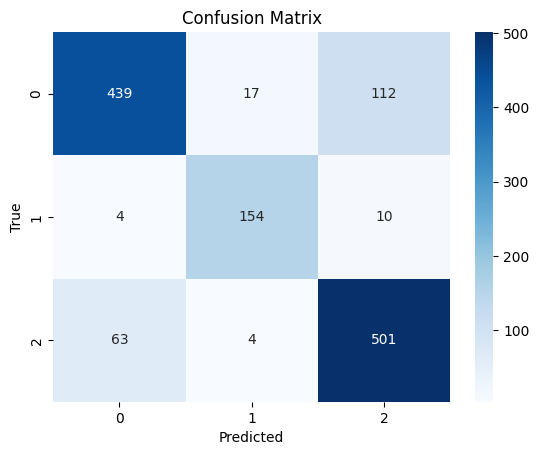

In [23]:
def evaluate_model(model, X_mel_test, X_yamnet_test, y_test):
    """Evaluates a trained model using test data and displays a classification report and confusion matrix.

    Parameters
    ----------
    model : keras.Model
        Trained hybrid model.
    X_mel_test : np.ndarray
        Mel spectrogram features from the test set.
    X_yamnet_test : np.ndarray
        YAMNet embedding features from the test set.
    y_test : np.ndarray
        One-hot encoded ground truth labels.

    Returns
    -------
    None
        Prints the classification report and plots the confusion matrix.

    Example
    -------
    >>> evaluate_model(model, X_mel_test, X_yamnet_test, y_test)
    """
    # Predict class probabilities
    y_pred = model.predict([X_mel_test, X_yamnet_test])

    # Convert predictions and true labels to class indices
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Display classification report
    print(classification_report(y_true, y_pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return y_true, y_pred_labels

y_true, y_pred_labels = evaluate_model(model, X_mel_val, X_yamnet_val, y_val)

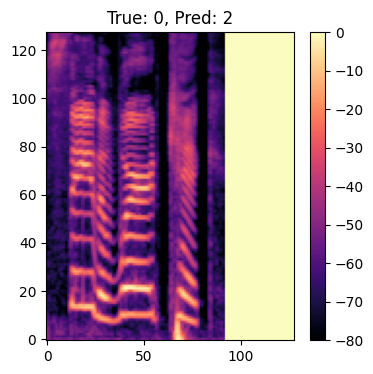

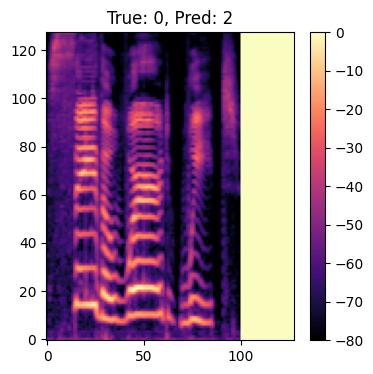

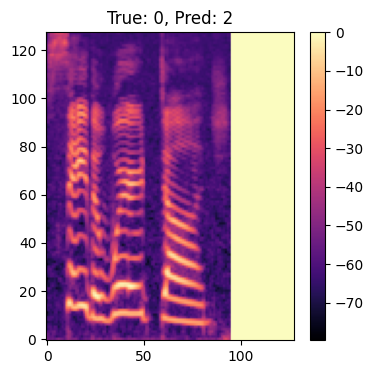

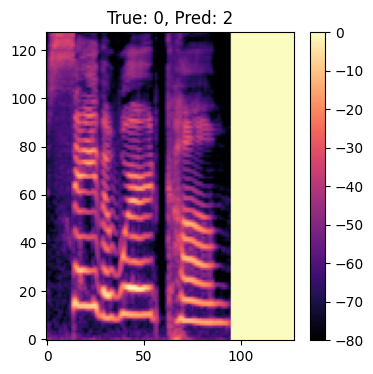

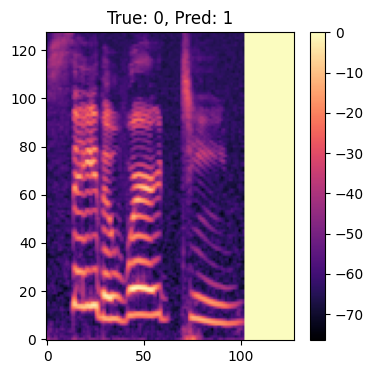

In [24]:
# ---❌ VISUALIZE MISCLASSIFICATIONS ---
def visualize_misclassifications(X_mel_test, y_true, y_pred_labels, num_samples=5):
    """Displays spectrograms of misclassified audio samples.

    Parameters
    ----------
    X_mel_test : np.ndarray
        Array of Mel spectrogram test samples.
    y_true : np.ndarray
        True class labels (as integers).
    y_pred_labels : np.ndarray
        Predicted class labels (as integers).
    num_samples : int
        Number of misclassified samples to visualize.

    Returns
    -------
    None
        Shows matplotlib plots for each misclassified example.

    Example
    -------
    >>> visualize_misclassifications(X_mel_test, y_true, y_pred_labels)
    """
    misclassified = np.where(y_pred_labels != y_true)[0]
    for i in misclassified[:num_samples]:
        plt.figure(figsize=(4, 4))
        plt.imshow(X_mel_test[i].squeeze(), aspect='auto', origin='lower', cmap='magma')
        plt.title(f"True: {y_true[i]}, Pred: {y_pred_labels[i]}")
        plt.colorbar()
        plt.show()

visualize_misclassifications(X_mel_val, y_true, y_pred_labels, num_samples=5)

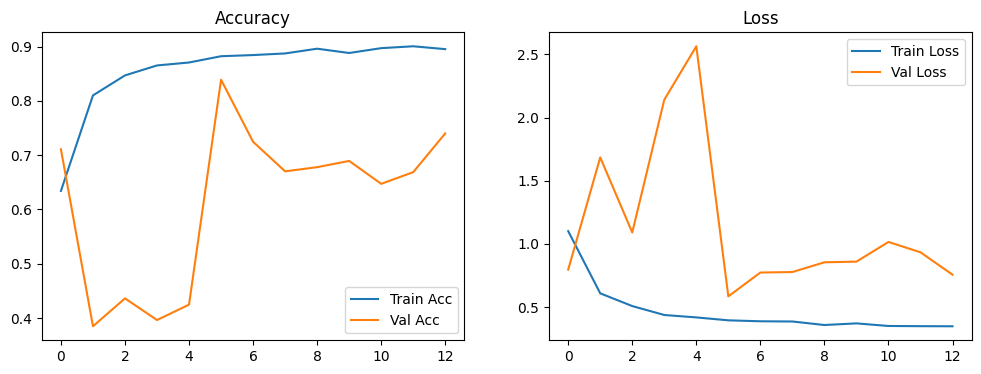

In [27]:
def plot_training_history_from_file(filepath="training_history.pkl"):
    """Loads and plots training and validation accuracy and loss from a saved history file.

    Parameters
    ----------
    filepath : str
        Path to the pickle file containing the training history.

    Returns
    -------
    None
        Displays matplotlib plots of accuracy and loss curves.

    Example
    -------
    >>> plot_training_history_from_file("training_history.pkl")
    """
    with open(filepath, "rb") as f:
        history_data = pickle.load(f)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_data['accuracy'], label='Train Acc')
    plt.plot(history_data['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_data['loss'], label='Train Loss')
    plt.plot(history_data['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()


plot_training_history_from_file("training_history.pkl")